<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/Basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a simple 2 class classifier for medical images

Here we build a simple deep learning model with little description of what is going on. The main purpose is to give you a sense of what is possible AND that YOU CAN DO THIS!

### Preparing the notebook


OK, let's begin by setting the environment for this notebook by installing MONAI.

In [1]:
# Cell 1
# Installing required libraries
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.8 MB/s eta 0:00:00


In [2]:
# Cell 2
# Import the required python types for type hinting
# Turn off the notebook warnings

from typing import List, Tuple, Dict, Union, Callable, Iterable
import warnings

warnings.filterwarnings("ignore")

Next, we write a basic wrapper to make our code as deterministic as possible. As you probably know, deterministic programming will make most of our code generate the same outputs if it is run multiple times. In other words, random generators in a deterministic algorithm will create the same values every time they are called (which is why they are technically 'pseudorandom'). 

*   For more information about deterministic programming, read [here](https://www.geeksforgeeks.org/difference-between-deterministic-and-non-deterministic-algorithms/).  
*   For more information about wrappers in Python, read [here](https://www.geeksforgeeks.org/function-wrappers-in-python). 

If you look at the next cell, you will find steps that set up Python, PyTorch, and MONAI to work in a deterministic way. However, making an algorithm deterministic is more complicated than it seems, especially when coding in Google Colab. Google Colab is set up to assign you an actual graphic processing unit (GPU) every time you start a new session. Unfortunately, there is currently no way to make this assignment deterministic to the best of our knowledge. If hardware like the GPU is changed (particularly to a different type of GPU), results may be different, even if you use wrappers like what have here.


In [3]:
# Cell 3

import torch
import os
import numpy as np
import monai
import random
from functools import wraps


Next, let's check if a GPU is assigned to our session. Before running the following cell, make sure your Colab runtime is set to GPU. To do so, click on Runtime -> Change runtime type, and select GPU for the hardware accelerator.  

---

>
**Question**: Why do we need to connect to a GPU? The answer is that training deep learning models often involves running processes that are highly computational-dependent. Running these processes on central processing units (CPUs) one after the other will take a lot of time. However, GPUs can run the deep learning computations in parallel, significantly reducing the time needed for training. 

---

In [4]:
# Cell 4

# Selecting the processor device. Make sure your colab runtype is set to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Checking the GPU device
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB


### Data collection

Now that the environment is ready, we need to download some data to work on. For this chapter and the next one, we will work with a public Chest X-Ray (CXR) dataset that contains images for normal and pneumonia patients. The original dataset is found [here](https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded), but we already moved that data to a Google Drive location to speed up the download process. That is the source from where you will download the data in the following cell.

In [5]:
# Cell 5

!rm -rf ./sample_data/
import gdown

# only download if not there (for restarts)
if not os.path.exists("./CTHead"):
    gdown.download(
        "https://docs.google.com/uc?export=download&id=1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh",
        "MedNIST.zip",
        quiet=False,
    )
    !unzip -q MedNIST.zip

    os.remove("MedNIST.zip")



Downloading...
From: https://docs.google.com/uc?export=download&id=1mqgBKTB0MtGf8Fhc8HaedJyiD8yMoXOh
To: /content/MedNIST.zip
100%|██████████| 2.02M/2.02M [00:00<00:00, 151MB/s]


The above cell will download the data and put it in the disk space Google Colab provided for our notebook. Feel free to click on the "Files" icon on the left side of the screen and take a look at the downloaded files. These files were downloaded as a zipped folder, unzipped, and stores as CTHead or MRBrain.



Now we can collect the paths to images available in this downloaded dataset. Unfortunately, the original folder has all the images of a type together, so we will just split those that have '9.jpg' in the name as the test set and all others as TRAIN. That gets us a 90-10 split. 

In [6]:
# Cell 6

# Collecting all image paths, along with their associated labels and sets


def collect_imageinfo_list(images_dirpath: str) -> List:
    """
    Return a list of information tuples for all images, where each information
    tuple includes the associated path, label, and set for each image.
    Parameters:
      - images_dirpath (str): Path to the directory including all images.
      - imageinfo_list (List): a list of (file_path, file_label, file_set)
      for each image file.
    """
    imageinfo_list = list()
    for root, dirs, files in os.walk(images_dirpath):
        for file in files:
            file_path = os.path.join(root, file)
            dir_path = os.path.dirname(file_path)
            if 'CTHead' in dir_path or 'MRBrain' in dir_path:  # for now, exclude other images
                if file.lower().endswith(".jpeg") or file.lower().endswith(".jpg"):
#                    dir_path = os.path.dirname(file_path)
    #                file_label = dir_path.split("/")[-1]
                    file_set = "TEST" if "9.jpg" in file else "TRAIN"  # simple way to get 10% as test
                    file_label = "CTHead" if "CTHead" in dir_path else "MRBrain"
                    imageinfo_list.append((file_path, file_label, file_set))
    return imageinfo_list


imageinfo_list = collect_imageinfo_list(".")  # we are working from the current directory

train_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "TRAIN"
]
train_mrbain_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "MRBrain"]
)
train_ctbrain_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTHead"]
)
test_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "TEST"
]
test_mrbain_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "MRBrain"]
)
test_ctbrain_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "CTHead"]
)

print(
    f"Number of images in the training set: {len(train_imageinfo_list)} --> \
MRBrain: {train_mrbain_count} - CTHead: {train_ctbrain_count}"
)
print(
    f"Number of images in the test set: {len(test_imageinfo_list)} --> \
MRBrain: {test_mrbain_count} - CTHead: {test_ctbrain_count}"
)

Number of images in the training set: 540 --> MRBrain: 270 - CTHead: 270
Number of images in the test set: 60 --> MRBrain: 30 - CTHead: 30


### Data investigation

It is always a good idea to look at your data before applying training, as there can often be 'surprises'. First, we can visualize some random images from the data to see how they look. The following cell will visualize nine random images and their associated labels.

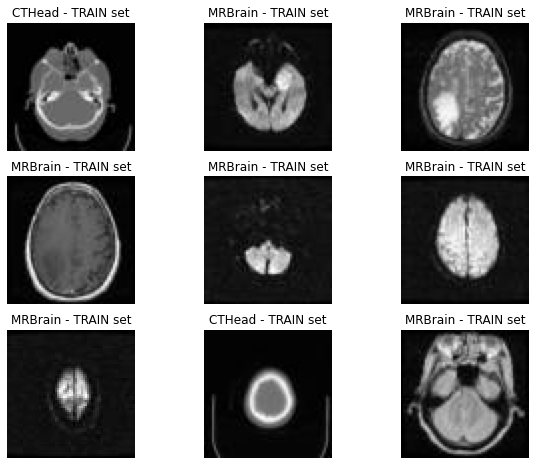

In [7]:
# Cell 7

# Plotting sample images from the original data
import matplotlib.pyplot as plt
from skimage.io import imread

def plot_sample_images():
    """
    Plot 9 sample images from the imaging dataset, while printing their
    associated labels and sets.
    """
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    random_imagesinfo_items = random.choices(imageinfo_list, k=9)
    for i, imageinfo in enumerate(random_imagesinfo_items):
        image = imread(imageinfo[0])
        axes[i // 3, i % 3].imshow(image, cmap="gray")
        axes[i // 3, i % 3].axis("off")
        axes[i // 3, i % 3].set_title(f"{imageinfo[1]} - {imageinfo[2]} set")
    plt.show()


plot_sample_images()

### Building datasets and data loaders

We mentioned that one must 'flow' the data through the GPU memory for each epoch. DataLoaders are one way to make that happen. There are lots of details in the next cell that we will explore later. For now, just take it on faith that this needs to be done...


In [8]:
# Cell 8

# Building datasets and dataloaders using MONAI

from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    ResizeD,
    Compose,
    NormalizeIntensityD,
    RandRotateD,
    RandZoomD,
    AddChannelD,
    LambdaD,
    ToTensorD,
    RepeatChannelD,
    Rotate90d,
    SelectItemsd,
)
from monai.data import Dataset
from torch.utils.data import DataLoader


def build_dataloaders(
    train_imageinfo_list: List = train_imageinfo_list,
    test_imageinfo_list: List = test_imageinfo_list,
    image_size: int = 224,
    augment_train_data: bool = False,
    fct_to_train: float = 1.0,
    fct_to_valid: float = 0.5,
) -> DataLoader:

    def worker_init_fn(worker_id):
        np.random.seed(np.random.get_state()[1][0] + worker_id)

    label_dict = {"MRBrain": 1, "CTHead": 0}
    train_data_list = [
        {"image": imageinfo[0], "label": label_dict[imageinfo[1]]}
        for imageinfo in train_imageinfo_list
    ]
    test_data_list = [
        {"image": imageinfo[0], "label": label_dict[imageinfo[1]]}
        for imageinfo in test_imageinfo_list
    ]

    # Shuffling the data before fractioning it
    # Note: We assume that each datapoint in the test_data_list belongs to
    # a seprate patient.
    random.shuffle(train_data_list)
    random.shuffle(test_data_list)

    # Using fractions of data
    P_train_list = [x for x in train_data_list if x["label"] == 1]
    N_train_list = [x for x in train_data_list if x["label"] == 0]
    P_test_list = [x for x in test_data_list if x["label"] == 1]
    N_test_list = [x for x in test_data_list if x["label"] == 0]
    touse_train_data = (
        P_train_list[: int(len(P_train_list) * fct_to_train)]
        + N_train_list[: int(len(N_train_list) * fct_to_train)]
    )
    touse_valid_data = (
        P_test_list[: int(len(P_test_list) * fct_to_valid)]
        + N_test_list[: int(len(N_test_list) * fct_to_valid)]
    )
    touse_test_data = [x for x in test_data_list if x not in touse_valid_data]

    # Building MONAI transforms
    Aug_transforms = Compose(
        [
            LoadImageD(keys="image"),
            EnsureChannelFirstD(keys="image"),
            LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim == 3 else x),
            AddChannelD(keys="image"),
            ResizeD(keys="image", spatial_size=(image_size, image_size)),
            NormalizeIntensityD(keys="image"),
            RandRotateD(keys="image", mode="bilinear", range_x=0.26, prob=0.5),
            RandZoomD(keys="image", mode="bilinear"),
            Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
            ToTensorD(keys=["image", "label"]),
            RepeatChannelD(keys="image", repeats=3),
            SelectItemsd(keys=["image", "label"]),
        ]
    )
    NoAug_transforms = Compose(
        [
            LoadImageD(keys="image"),
            EnsureChannelFirstD(keys="image"),
            LambdaD(keys="image", func=lambda x: x[0, :, :] if x.ndim == 3 else x),
            AddChannelD(keys="image"),
            ResizeD(keys="image", spatial_size=(image_size, image_size)),
            NormalizeIntensityD(keys="image"),
            Rotate90d(keys="image", k=3, spatial_axes=(0, 1)),
            ToTensorD(keys=["image", "label"]),
            RepeatChannelD(keys="image", repeats=3),
            SelectItemsd(keys=["image", "label"]),
        ]
    )

    # Building MONAI datasets
    if augment_train_data:
        train_dataset = Dataset(touse_train_data, transform=Aug_transforms)
    else:
        train_dataset = Dataset(touse_train_data, transform=NoAug_transforms)
    valid_dataset = Dataset(touse_valid_data, transform=NoAug_transforms)
    test_dataset = Dataset(touse_test_data, transform=NoAug_transforms)

    # Building MONAI dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=1,
        worker_init_fn=worker_init_fn,
    )
    return train_loader, valid_loader, test_loader


# Testing the shape and dtype for a sample batche from the training dataloader:

train_loader, valid_loader, test_loader = build_dataloaders()
sample_batch = next(iter((train_loader)))


The above cell prints out the shape, dtype (data type) and labels of the images coming out of our data loaders. We can also proceed and visualize some examples of these images to ensure that we haven't messed them up:

In [20]:
# Cell 9
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import shutil
from torchsummary import summary

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,1)   # Channels, Filters, kernel size, stride
        self.conv2 = nn.Conv2d(32,64,3,1)
        v = 64*220*220
        self.fc1 = nn.Linear(v, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self,x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = NeuralNet().to(device)

summary(model, input_size=(3, 224, 224))

RuntimeError: ignored

In [ ]:
# Cell 10

# A function to evaluate a model's performance on the test_loader

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


def evaluate_model(
    model: Callable, test_loader: Iterable = test_loader, plot_cm: bool = True
) -> float:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    labels_list = list()
    preds_list = list()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            labels_list.append(labels)
            preds_list.append(preds)
        all_labels = torch.cat(labels_list).cpu()
        all_preds = torch.cat(preds_list).cpu()
        accuracy = (all_preds == all_labels).sum().item() / len(all_labels)

    if plot_cm:
        cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
        ax = plt.subplot()
        sns.heatmap(cm, annot=True, fmt="g", ax=ax)
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Confusion Matrix - accuracy: {accuracy:.2f}")
        ax.xaxis.set_ticklabels(["MRBrain", "CTHead"])
        ax.yaxis.set_ticklabels(["MRBrain", "CTHead"])

    return accuracy

In [ ]:
# Cell 11

# Evaluating the performance of a non-trained model

_ = evaluate_model(model)

The figure above is a confusion matrix. It gets its name because it shows how many times the model confused one class of inputs with another (Ct vs MR in this case).
This shows that all cases are predicted as MR brains, while there are actually 15 of each (your results might be different depending on the random selection of cases).


In [ ]:
# Cell 12

# create the function to train the classifier
def train_classifier(
    model: torch.nn.Module,
    model_name: str,
    train_loader: Iterable,
    valid_loader: Iterable,
    criterion: Callable,
    optimizer: torch.optim,
    num_epochs: int,
    plot_curves: bool,
    scheduler: torch.optim.lr_scheduler
):
    """
    Train a classifier model using pytorch and the given parameters.
    Parameters:
      model (Callable): any pytorch module,
      model_name (str): name of the model to be saved.
      train_loader (Iterable): dataloader for training data,
      valid_loader (Iterable): dataloader for validation data,
      criterion (Callable): any loss function,
      optimizer (torch.optim): a pytorch optimizer,
      num_epochs (int): number of epochs to train the model,
      plot_charts (bool): whether or not to plot the training and validation loss
      and accuracy curves.
    """

    # Sending the model to device (preferably GPU)
    model.to(device)

    # Releaseing the GPU memory. This is not necessary, but a good practice to do
    # before starting new training sessions.
    with torch.no_grad():
        torch.cuda.empty_cache()

    # Building a saving directory for models
    model_save_dir = os.path.join("Best_Models", model_name)
    if os.path.exists(model_save_dir):
        shutil.rmtree(model_save_dir)
    os.makedirs(model_save_dir, exist_ok=True)

    # lists to log the epoch values
    epoch_train_loss_list = list()
    epoch_train_accuracy_list = list()
    epoch_valid_loss_list = list()
    epoch_valid_accuracy_list = list()

    # Starting the training loop
    for epoch in range(1, num_epochs + 1):
        print("-" * 20, f"\nStarting epoch: {epoch}/{num_epochs}")

        ## training
        model.train()
        steps_train_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(train_loader, unit="batch"):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            ### Zero the parameter gradients
            optimizer.zero_grad()

            ### Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ### Accumulating the loss and number of correct predictions in step
            steps_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch training loss and accuracy
        epoch_train_loss = steps_train_loss / len(train_loader)
        epoch_train_loss_list.append(epoch_train_loss)
        epoch_train_accuracy = steps_correct_predictions / len(train_loader.dataset)
        epoch_train_accuracy_list.append(epoch_train_accuracy)

        ## validation
        model.eval()
        steps_valid_loss = 0.0
        steps_correct_predictions = 0

        for batch in tqdm(valid_loader, unit="batch"):
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            ### Accumulating the loss and number of correct predictions in step
            steps_valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            steps_correct_predictions += (predicted == labels).sum().item()

        ## Measuring the epoch validation loss and accuracy
        epoch_valid_loss = steps_valid_loss / len(valid_loader)
        epoch_valid_loss_list.append(epoch_valid_loss)
        epoch_valid_accuracy = steps_correct_predictions / len(valid_loader.dataset)
        epoch_valid_accuracy_list.append(epoch_valid_accuracy)

        ## Printing the logs
        print(
            f"train loss: {epoch_train_loss:.2f} | \
    train accuracy: {epoch_train_accuracy:.2f}"
        )
        print(
            f"valid loss: {epoch_valid_loss:.2f} | \
    valid accuracy: {epoch_valid_accuracy:.2f}"
        )

        ## Saving the best model
        if epoch == 1:
            best_valid_loss = epoch_valid_loss
            weight_name = f"{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth"
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
        elif epoch_valid_loss < best_valid_loss:
            weight_name = f"{model_name}_Epoch{epoch}_ACC={epoch_valid_accuracy}.pth"
            torch.save(model.state_dict(), os.path.join(model_save_dir, weight_name))
            best_valid_loss = epoch_valid_loss
        scheduler.step()


    # Printing the best model
    print(f"\nTrainng was over. The best model was: {weight_name}")

    # Plotting the loss and accuracy curves
    if plot_curves:
        epoch_train_loss_list.insert(0, 0)
        epoch_train_accuracy_list.insert(0, 0)
        epoch_valid_loss_list.insert(0, 0)
        epoch_valid_accuracy_list.insert(0, 0)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].plot(epoch_train_loss_list, color="blue", label="training")
        axes[0].plot(epoch_valid_loss_list, color="orange", label="validation")
        axes[0].set_xlim(1, len(epoch_valid_loss_list) + 1)
        axes[0].set_title("Loss curves")
        axes[0].legend()
        axes[1].plot(epoch_train_accuracy_list, color="blue", label="training")
        axes[1].plot(epoch_valid_accuracy_list, color="orange", label="validation")
        axes[1].set_xlim(1, len(epoch_train_accuracy_list) + 1)
        axes[1].set_title("Accuracy curves")
        axes[1].legend()

    # Loading the best weights and returning the model
    model.load_state_dict(torch.load(os.path.join(model_save_dir, weight_name)))
    return model

Finally we are ready to train the model! We will just do 4 epochs and then see what the performance is.

In [ ]:
# Cell 13

# Doing a base-line training with a non-trained and not-pretrained model
#  You may need to vertically scroll within the code output window
# in order to see all of the output.
import time
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR



criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 4
scheduler = StepLR(optimizer, step_size = 4, gamma = 0.5)

# the next line will time how long the line after it takes to complete
t1 = time.perf_counter()


model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


In [ ]:
# Cell 14

# once again computing the confusion matrix, but now for our trained model

_ = evaluate_model(model)

You can see that with just a few epochs, we are getting very good results. Of course, a human would also pick this up pretty quickly, but it shows that for fairly obvious tasks, these tools can get results quickly.

My results on a T4
<br>
```markdown
Model      Accuracy    Time(s)
Resnet18      .86       27.     
Resnet50      .83       38.2
VGG16         .97       66.7
```

Does this make sense? The smallest model (ResNet18) ran the fastest and had good accuracy!!!  This goes to show that you can't just throw data at the most complex model and expect to get the best results.  But Why not????

For each epoch, you can see that as the bar was going across to show training, it shows 68/68 when the epoch is done. Why is the number 68--what is that number?

# Stop Here

# Part 2: Optimizers


Now we will try a few different optimizers so you can see how they compare. Feel free to experiement here--this is just a starting point!!
A list of the optimizers that are built into PyTorch and their parameters is here:
https://pytorch.org/docs/stable/optim.html


In [ ]:
# Cell 15

criterion = torch.nn.CrossEntropyLoss()


optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


num_epochs = 4
# the next line will time how long the line after it takes to complete

t1 = time.perf_counter()

print ("SGD")
model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer_SGD,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)
print (50*'-')



In [ ]:
# Cell 16
model = build_model(arch="resnet18")
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)

t1 = time.perf_counter()

print ("RMS Prop")
model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


In [ ]:
# Cell 17
model = build_model(arch="resnet18")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


t1 = time.perf_counter()

print ("Adam")
model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


** Adam seems to be a clear winner with very good results in the very first Epoch! This is often the case, which is why Adam is a popular optimizer.

Now lets look at learning rate scehdulers. We will switch back to SGD so the impact is a bit more clear.
Choices for learning rate schedulers is also found on that page linked above, about half-way down. Some options are: StepLR, CoseineAnnealingLR, CyclicLR, OneCycleLR, CosineAnnealingWarmRestarts

In [ ]:
# Cell 18

model = build_model(arch="resnet18")

# StepLR reduces the LR by a multiplicative factor
scheduler = StepLR(optimizer, 
                   step_size = 4, # Period of learning rate decay
                   gamma = 0.5) # Multiplicative factor of learning rate decay


optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)
t1 = time.perf_counter()


model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


In [ ]:
# Cell 19

model = build_model(arch="resnet18")
# need to recreate the optimizer so that there aren't already values there...
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)

# this uses the cosine function to change the LR from low to high to low
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                       base_lr = 1e-4, # Upper learning rate boundaries in the cycle for each parameter group
                       max_lr = 1e-3) # Upper learning rate boundaries in the cycle for each parameter group

t1 = time.perf_counter()


model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)



Please experiement with different values above.
Becuase of time, we have a rather simple problem with few examples and thus we get good results quite quickly. 
But in the real world, you may get a benefit from experimenting with different optimizers and different learning rates and schedulers.
If there was 1 best optimizer or 1 best lr_scheduler, there wouldn't be lots of choices...

# End Part 2 on Optimizers here!


#Part 3: Cost Functions (Loss Functions)
Here we will experiment with different cost functions. There is not quite such a large range of cost functions as optimizers, and the right cost function is rather specific to a task: You shouldn't use a Dice Score for a classification task!


In line 8 of Cell 13, we set the loss function as:
criterion = torch.nn.CrossEntropyLoss()

Lets start by setting the baseline performance again but then we will try a few other cost functions


In [ ]:
# Cell 20

model = build_model(arch="resnet18")
# baseline performance
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 4
# the next line will time how long the line after it takes to complete

t1 = time.perf_counter()


model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Just as there are many options for optimizers, there are many options for loss (cost) functions. These are listed on the pytorch page here:
https://pytorch.org/docs/stable/nn.html#loss-functions

Unfortunately using simpler loss functions like L1Loss or MSELoss is not easily compatible with how we defined our trainer above. But most other cost functions work.

In [ ]:
# Cell 21

model = build_model(arch="resnet18")
criterion = torch.nn.NLLLoss()   # Negative Log Likelihood loss
learning_rate = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 4

t1 = time.perf_counter()


model = train_classifier(
    model=model,
    model_name=MyModel,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    plot_curves=True,
    scheduler=scheduler
)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


Wow--most times, the performance degrades with more epochs! How can that happen?


# Extra Credit
Rewrite the dataloader (Cell #6) and the classifier to classify all 6 different types of images!  
I will get you started on the dataloader

In [ ]:
# Cell 22
img_classes = ['CTAbd', 'CTChest', 'CTHead', 'CXR', 'MRBrain', 'MRBreast']

def collect_imageinfo_list(images_dirpath: str) -> List:
    """
    Return a list of information tuples for all images, where each information
    tuple includes the associated path, label, and set for each image.
    Parameters:
      - images_dirpath (str): Path to the directory including all images.
      - imageinfo_list (List): a list of (file_path, file_label, file_set)
      for each image file.
    """
    imageinfo_list = list()
    for root, dirs, files in os.walk(images_dirpath):
        for dir in dirs:
            if dir in img_classes:
                dir_path = os.path.join(root,dir)
                flist = os.listdir(dir_path)
                for file in flist:
                    file_path = os.path.join(dir_path, file)
                    print (file_path)
                    if file.lower().endswith(".jpeg") or file.lower().endswith(".jpg"):
                        file_set = "TEST" if "9.jpg" in file else "TRAIN"  # simple way to get 10% as test
                        imageinfo_list.append((file_path, dir, file_set))
    return imageinfo_list


imageinfo_list = collect_imageinfo_list(".")  # we are working from the current directory

train_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "TRAIN"
]
train_mrbain_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "MRBrain"]
)
train_ctbrain_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTHead"]
)
test_imageinfo_list = [
    imageinfo for imageinfo in imageinfo_list if imageinfo[2] == "TEST"
]
test_mrbain_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "MRBrain"]
)
test_ctbrain_count = len(
    [imageinfo for imageinfo in test_imageinfo_list if imageinfo[1] == "CTHead"]
)
train_ctabd_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTAbd"]
)
test_ctabd_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTAbd"]
)
train_ctchest_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTChest"]
)
test_ctchest_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CTChest"]
)
train_cxr_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CXR"]
)
test_cxr_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "CXR"]
)
train_mrbreast_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "MRBreast"]
)
test_mrbreast_count = len(
    [imageinfo for imageinfo in train_imageinfo_list if imageinfo[1] == "MRBreast"]
)


print(
    f"Number of images in the training set: {len(train_imageinfo_list)} --> \
MRBrain: {train_mrbain_count} - CTHead: {train_ctbrain_count} - CTAbd: {train_ctabd_count} - CXR: {train_cxr_count} - "
)
print(
    f"Number of images in the test set: {len(test_imageinfo_list)} --> \
MRBrain: {test_mrbain_count} - CTHead: {test_ctbrain_count}"
)

In [ ]:
# Cell 7

# Plotting sample images from the original data
import matplotlib.pyplot as plt
from skimage.io import imread

def plot_sample_images():
    """
    Plot 9 sample images from the imaging dataset, while printing their
    associated labels and sets.
    """
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    random_imagesinfo_items = random.choices(imageinfo_list, k=9)
    for i, imageinfo in enumerate(random_imagesinfo_items):
        image = imread(imageinfo[0])
        axes[i // 3, i % 3].imshow(image, cmap="gray")
        axes[i // 3, i % 3].axis("off")
        axes[i // 3, i % 3].set_title(f"{imageinfo[1]} - {imageinfo[2]} set")
    plt.show()


plot_sample_images()